# Bitcoin - Complex Graph Analysis

## Steps
1. [Parse blockchain](#Parse-blockchain-using-btcgraph.py)
2. [Data preparation (BigQuery)](#2.-Data-preparation-(BigQuery))  
    2.1. [Upload data](#2.1.-Upload-data-to-Google-Big-Query)  
    2.2. [Create new indices](#2.2.-Create-indices-for-every-address)  
    2.3. [Build edge list](#2.3.-Build-edge-list-with-timestamps-using-the-new-indices)  
    2.4. [Export data to GCS](#2.4.-Export-dataset-to-Google-Cloud-Storage)  
    2.5. [Download edge list from GCS](#2.5.-Download-edge-list-from-google-cloud-as-csv-(without-timestamp))
3. [Graph construction](#3.-Build-Graph-using-NetworKit)
4. [Analysis](#4.-Analysis)  
    4.1. The graph object  
    4.2. Connected Components  
    4.3. [](#)

***

## 1. Parse blockchain using btcgraph.py

In [5]:
%run run.py -loc data -raw 1 -wt 1

Starting btc graph version 0.1.0 with the following arguments:
current wd:       /home/nero/python/wu/btc/python-bitcoin-graph
startfile:        blk00000.dat 
endfile:          deactivated
starttx:          deactivated
endtx:            deactivated
endts:            deactivated
blklocation:      data         
format:           deactivated
rawedges:         activated
withts:           activated
googlebigquery:   deactivated

Initializing...
[########################################]

10:56:40  -  New BtcGraph initialized
10:56:41  -  Start building...
10:56:41  -  Block File # 0/4
10:56:41  -  Processing data/blk00000.dat
10:57:09  -  Graph has       18,216,888 bytes
10:57:09  -  Graph has               17 mb
10:57:09  -  ---  -------   ----------------------------
10:57:09  -  -->  23.2 GB   total memory
10:57:09  -  -->  16.6 GB   of memory available
10:57:09  -  -->   5.7 GB   memory used
10:57:09  -  -->   0.4 GB   memory used by this process
10:57:09  -  -->  28.1  %   of memory us

***

## 2. Data preparation (BigQuery)
   * Fetch distinct addresses 
   * Create index ID for each address
   * Create edge list from transactions with new indexes

In [2]:
import os 
from google.cloud import storage, bigquery

credentials_path = ".gcpkey/wu-btcgraph.json"
bucket_name      = "wu-bitcoin"
file_name        = "btc"
target_folder    = "graph"
bq_project       = "wu-btcgraph"
bq_dataset       = "btc"
bq_table         = "bitcoin_transactions"

if not os.path.isdir(f'./{target_folder}'):
    os.makedirs(f'./{target_folder}')

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credentials_path

### 2.1. Upload data to Google Big Query 

In [16]:
%run run.py -gbq 1

startfile:        deactivated
endfile:          deactivated
starttx:          deactivated
endtx:            deactivated
endts:            deactivated
blklocation:      deactivated
format:           deactivated
rawedges:         deactivated
withts:           deactivated
googlebigquery:   activated

Initializing...
[########################################]

raw_blk_0.csv      successfully uploaded   
raw_blk_1.csv      successfully uploaded   
raw_blk_2.csv      successfully uploaded   
[###]
-----------------------------------------


### 2.2. Create indices for every address

In [7]:
# Code taken from the official docs
# https://cloud.google.com/bigquery/docs/quickstarts/quickstart-client-libraries

client = bigquery.Client()

query = """
    CREATE OR REPLACE TABLE `{0}.{1}.addresses` AS
        SELECT
          ROW_NUMBER() OVER() - 1 id, addr FROM 
          (
            SELECT DISTINCT addr FROM 
                (
                SELECT `to` AS addr FROM `{0}.{1}.{2}`
                UNION ALL
                SELECT `from` AS addr FROM `{0}.{1}.{2}` 
                )
              ORDER BY addr 
            ) 
            ORDER BY id
        """.format(bq_project,bq_dataset,bq_table)

query_job = client.query(query)
query_job.result()

### 2.3. Build edge list with timestamps using the new indices

In [4]:
try: client
except: client = bigquery.Client()
query = """
        CREATE OR REPLACE TABLE `{0}.{1}.graph_with_ts` AS
            SELECT  A.ts, B.from_id, C.to_id FROM 
            (
              (SELECT * FROM `{0}.{1}.{2}`) A
              LEFT JOIN 
              (SELECT id AS from_id, addr FROM `{0}.{1}.addresses`) B ON A.from = B.addr
              LEFT JOIN 
              (SELECT id AS to_id, addr FROM `{0}.{1}.addresses`) C ON A.to = C.addr
            )
        """.format(bq_project,bq_dataset,bq_table)

query_job = client.query(query)
query_job.result()

### 2.4. Export dataset to Google Cloud Storage

In [7]:
# Code taken from the official docs
# https://cloud.google.com/bigquery/docs/samples/bigquery-extract-table

destination_uri = "gs://{}/{}_*.csv".format(bucket_name, file_name)
dataset_ref = bigquery.DatasetReference(bq_project, bq_dataset)
table_ref = dataset_ref.table("graph_with_ts")

extract_job = client.extract_table(
    table_ref,
    destination_uri,
    # Location must match that of the source table.
    location="US",
)  # API request
extract_job.result()  # Waits for job to complete.

print(
    "Exported {}:{}.{} to {}".format(bq_project, bq_dataset, bq_table, destination_uri)
)

NameError: name 'project' is not defined

### 2.5. Download edge list from google cloud as csv (without timestamp)

In [7]:
storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)
file_names = map(lambda x: str(x).split(",")[1].strip(), list(bucket.list_blobs()))
for fn in file_names:
    if fn.startswith("{}_".format(file_name)):
        blob = bucket.blob(fn)
        blob.download_to_filename(target_folder + "/" + fn)
        print(f"{bucket_name}.{fn} copied to {target_folder}/{fn}")

wu-bitcoin.btc_000000000000.csv copied to graph/btc_000000000000.csv
wu-bitcoin.btc_000000000001.csv copied to graph/btc_000000000001.csv


KeyboardInterrupt: 

***

## 3. Build Graph using NetworKit

In [4]:
target_folder = "testfolder"
file_location = target_folder
files = os.listdir(file_location)
files.remove("output")
G = graph.Graph() #graphio.EdgeListReader(',', 0, directed=True).read(file_location+"/"+files[0])
print("-------")
for file in range(21):
    print(file)
    #nr = int(re.search("[1-9].[0-9]+", file).group(0))
    with open(file_location+"/"+"testf"+str(file)+".csv", "r") as csvfile:
        spamreader = csv.reader(csvfile)
        for u, v in spamreader:
            G.addEdge(int(u), int(v), addMissing=True)
            


-------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [6]:
G.numberOfEdges()

210789327

In [8]:
from networkit import *
import csv
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
counter = 2
for j in range(12,35):
    with open("testfolder/testf{}.csv".format(counter), "w") as csvfile:
        spamwriter = csv.writer(csvfile)
        
        for i in range(int("{}0000000".format(j))-10000000,int("{}0000000".format(j))):
            spamwriter.writerow([i, i+1])
    counter += 1
        

KeyboardInterrupt: 

In [25]:
G = graph.Graph()
G.addEdge??

***

## 4. Analysis

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True
import networkit as nk
import os
import pandas as pd

if not os.path.isdir("./pictures"):
    os.mkdir("./pictures")

### 4.1. Bitcoin network

### 4.1.1. Transactions and edges per month

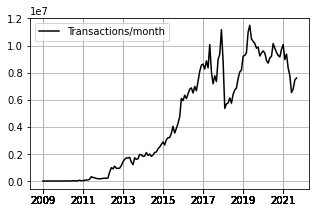

In [13]:
bq_table = "bitcoin_transactions_per_month"
query = """
        SELECT    * 
        FROM      `{}.{}.{}`
        """.format(bq_project,bq_dataset,bq_table)

df_txs   = pd.read_gbq(query, bq_project)[:-1]

# Create figure with size 5x3.15 inches
plt.figure(figsize=(5, 3.15))

# Join year and month to get month-of-year `moy`
df_txs["moy"] = df_txs["year"].astype(str)  + "/" + df_txs["month"].astype(str) 

# Plot chart
plt.plot(df_txs["moy"],df_txs["c"], color="k")

# Customize ticks
ticks_position = [i+"/1" for i in df_txs["year"].astype(str) if int(i) % 2 != 0]
ticks          = [tick.split("/")[0] for tick in ticks_position]
plt.xticks(ticks_position, ticks)

# Legend
plt.legend(["Transactions/month"])

#Save figure and show
plt.savefig("./pictures/txs_over_months.pdf")
plt.show()

NameError: name 'df_txs' is not defined

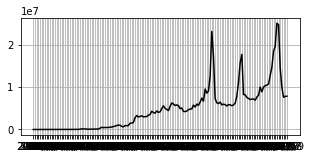

In [5]:
bq_table = "bitcoin_edges_per_month"
query = """
        SELECT    * 
        FROM      `{}.{}.{}`
        """.format(bq_project,bq_dataset,bq_table)

df_edges   = pd.read_gbq(query, bq_project)[:-1]

# Create figure with size 5x3.15 inches
plt.figure(figsize=(5, 2.15))

# Join year and month to get month-of-year `moy`
df_edges["moy"] = df_edges["year"].astype(str)  + "/" + df_edges["month"].astype(str) 

# Plot chart
plt.plot(df_edges["moy"],df_edges["c"]/10, color="k")
plt.plot(df_txs["moy"],df_txs["c"], color="#00629b", linestyle='dashed', linewidth=2)

# Customize ticks
ticks_position = [i+"/1" for i in df_edges["year"].astype(str) if int(i) % 2 != 0]
ticks          = [r"{}".format(tick.split("/")[0]) for tick in ticks_position]
plt.xticks(ticks_position, ticks, fontweight="ultralight")
plt.yticks(fontweight="book")

# Legend
plt.legend([r"$\#\ of\ Edges_{month} \ / \ 10$", r"$\#\ of\ Transactions_{month}$"])

#Save figure and show
plt.savefig("./pictures/txs_edges_over_months.pdf")
plt.show()

### 4.1.2. Cumulated number of Nodes and Edges & Densification Power Law

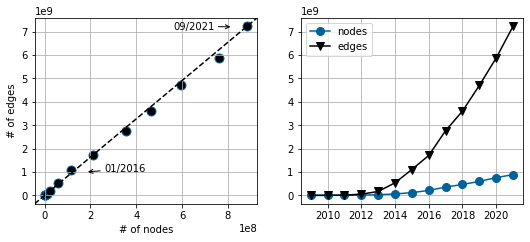

In [96]:
bq_table = "bitcoin_cum_node_count"
query = """
        SELECT    * 
        FROM      `{}.{}.{}`
        """.format(bq_project,bq_dataset,bq_table)
try:
    df_cnc
except:
    df_cnc   = pd.read_gbq(query, bq_project).sort_values("year")

df_ced   = df_edges.groupby("year").sum().drop("month", axis=1).cumsum()

# Create figure with size 4x4 inches
f, axs = plt.subplots(1, 2,figsize=(8, 4))

# Plot chart
axs[0].scatter(df_cnc["c"],df_ced["c"], s=80, color="k", edgecolors="#00629b")
axs[0].plot([0, 1], [0, 1], transform=axs[0].transAxes , color="k", ls="--", label='_nolegend_')

# Add month/year annoations
axs[0].annotate("09/2021", xy=(int(8.2e8), int(7.2e9)), xycoords='data',
            xytext=(int(5.6e8), int(7.1e9)), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))
axs[0].annotate("01/2016", xy=(int(1.8e8), int(1e9)), xycoords='data',
            xytext=(int(2.6e8), int(1e9)), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))
axs[0].set(xlabel="# of nodes", ylabel="# of edges")


# Plot chart
axs[1].plot(df_cnc["year"], df_cnc["c"], color="#00629b", marker="o", markersize=8, label="nodes")
axs[1].plot(df_cnc["year"], df_ced["c"], color="k", marker="v", markersize=8, label="edges")
axs[1].legend()


plt.tight_layout(pad=3)
#Save figure and show
plt.savefig("./pictures/densification.pdf")
plt.show()

In [56]:
# Densification Power law
# E(t) = N(t)^a

Et = df_ced.iloc[-1]
Nt = df_cnc["c"].iloc[-1]

a  = math.log(Et)/math.log(Nt)
print("Densification power law exponent of {:.3f}".format(a))

Densification power law exponent of 1.102


### 4.1. The graph object

In [4]:
nodes = G.numberOfNodes()
edges = G.numberOfEdges()
print(f"G has {nodes} nodes and {edges} edges")

'wu-btcgraph.json'

### 4.2. Connected components

In [2]:
cc = nk.components.ConnectedComponents(G)
cc.run()
print("number of components ", cc.numberOfComponents())

### 4.3. Degree distribution

In [5]:
dd = sorted(nk.centrality.DegreeCentrality(G).run().scores(), reverse=True)
plt.xscale("log")
plt.xlabel("degree")
plt.yscale("log")
plt.ylabel("number of nodes")
plt.plot(dd)
plt.show()

In [17]:
try:
    import powerlaw
    fit = powerlaw.Fit(dd)
except ImportError:
    print ("Module powerlaw could not be loaded")

'/home/nero/python/wu/btc/python-bitcoin-graph'

In [6]:
bucket = storage_client.bucket("wu-bitcoin")

In [9]:
blob = bucket.blob("btc.csv")
blob.download_to_filename("btcttttttttt.csv")

In [20]:
from networkit import *

In [18]:
g = graph.Graph()

In [19]:
g.numberOfEdges()

0

In [25]:
pd.DataFrame([(1,2,3),(3,4,5)], columns=["ts", "from", "to"])

,ts,from,to
0,1,2,3
1,3,4,5


In [4]:
"""
    CREATE OR REPLACE TABLE `{0}.{1}.addresses` AS
        SELECT
          ROW_NUMBER() OVER() - 1 id,
          addr
        FROM (
          SELECT
            DISTINCT addr
          FROM (
            SELECT
              `to` AS addr
            FROM
              `{0}.{1}.{2}`
            UNION ALL
            SELECT
              `from` AS addr
            FROM
              `{0}.{1}.{2}` )
          ORDER BY
            addr )
        ORDER BY
          id""".format(bq_project,bq_dataset,bq_table)

'\n    CREATE OR REPLACE TABLE `wu-btcgraph.btc.addresses` AS\n        SELECT\n          ROW_NUMBER() OVER() - 1 id,\n          addr\n        FROM (\n          SELECT\n            DISTINCT addr\n          FROM (\n            SELECT\n              `to` AS addr\n            FROM\n              `wu-btcgraph.btc.bitcoin_transactions`\n            UNION ALL\n            SELECT\n              `from` AS addr\n            FROM\n              `wu-btcgraph.btc.bitcoin_transactions` )\n          ORDER BY\n            addr )\n        ORDER BY\n          id'